Reporte de clasificación:
              precision    recall  f1-score   support

        Alta       0.83      0.76      0.79       212
        Baja       0.93      0.42      0.58       118
       Media       0.93      0.98      0.95      1670

    accuracy                           0.92      2000
   macro avg       0.89      0.72      0.78      2000
weighted avg       0.92      0.92      0.91      2000



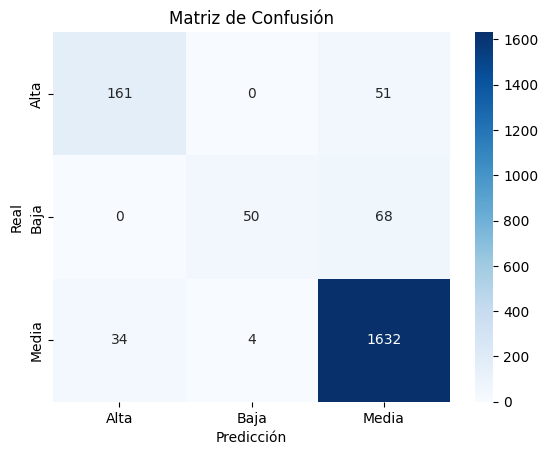

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np

# 1. Cargar los datos
df = pd.read_csv('https://gist.githubusercontent.com/javierIA/3ffc35bf38853a028136881a66cd66d9/raw/a029b85d55c32761b546a2996f43b0dbdddd9de4/data.csv')  # Asegúrate de que el CSV esté en la misma carpeta

# 2. Eliminar columnas innecesarias
columns_to_drop = [
    'name', 'combustible_estimado_l', 'eficiencia_km_l', 'potencia_motor_hp',
    'nivel_seguridad', 'edad_auto', 'score_calidad'
]
df = df.drop(columns=columns_to_drop, errors='ignore')

# 3. Codificación del target
label_encoder = LabelEncoder()
df['calidad_auto'] = label_encoder.fit_transform(df['calidad_auto'])

# 4. Codificación One-Hot de columnas categóricas
df = pd.get_dummies(df, columns=['fuel', 'seller_type', 'owner', 'tipo_carroceria'], drop_first=True)

# 5. Separar características y variable objetivo
X = df.drop(columns=['calidad_auto'])
y = df['calidad_auto']

# 6. Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Entrenar el modelo
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# 8. Guardar el modelo y columnas
joblib.dump(clf, 'modelo_calidad_auto.pkl')
joblib.dump(X.columns.tolist(), 'columnas_modelo.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# 9. Evaluación
y_pred = clf.predict(X_test)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 10. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [1]:
print("uwu")

uwu


In [ ]:
print("hola mundo")

hola mundo


In [ ]:
1+1


2